In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import numpy as np


In [2]:
# Define the transformation for the test dataset
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the test dataset
test_dir = r"C:\Users\venug\Downloads\archive\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [3]:
def evaluate_model(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    
    running_corrects = 0
    total = 0
    
    with torch.no_grad():  # No need to compute gradients
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            running_corrects += torch.sum(preds == labels.data).item()
            total += labels.size(0)
    
    accuracy = running_corrects / total
    return accuracy


In [4]:
def fine_tune_model(architecture_name, num_classes=4):
    if architecture_name == 'resnet18':
        model = models.resnet18(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)

    elif architecture_name == 'vgg16':
        model = models.vgg16(pretrained=True)
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs, num_classes)

    elif architecture_name == 'mobilenet_v2':
        model = models.mobilenet_v2(pretrained=True)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)

    elif architecture_name == 'efficientnet_b0':
        model = models.efficientnet_b0(pretrained=True)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)

    elif architecture_name == 'densenet121':
        model = models.densenet121(pretrained=True)
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)

    elif architecture_name == 'alexnet':
        model = models.alexnet(pretrained=True)
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs, num_classes)

    elif architecture_name == 'squeezenet':
        model = models.squeezenet1_0(pretrained=True)
        model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
        model.num_classes = num_classes

    else:
        raise ValueError("Unknown architecture. Choose from 'resnet18', 'vgg16', 'mobilenet_v2', 'efficientnet_b0', 'densenet121', 'alexnet', or 'squeezenet'")

    model = model.to(device)

    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    return model, criterion, optimizer, exp_lr_scheduler

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [8]:
models_to_test = ['resnet18', 'mobilenet_v2', 'efficientnet_b0', 'alexnet']

for arch in models_to_test:
    model = fine_tune_model(arch)[0]  # Load the model architecture
    model.load_state_dict(torch.load(f'{arch}_fine_tuned.pth'))  # Load the trained weights
    model = model.to(device)  # Send the model to the appropriate device
    
    accuracy = evaluate_model(model, test_loader, device)
    print(f'{arch} Test Accuracy: {accuracy:.4f}')


resnet18 Test Accuracy: 0.9960


c:\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


mobilenet_v2 Test Accuracy: 0.9962


c:\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


efficientnet_b0 Test Accuracy: 0.9867


c:\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


alexnet Test Accuracy: 0.9867


In [9]:
arch = 'squeezenet'
model = fine_tune_model(arch)[0]  # Load the model architecture
model.load_state_dict(torch.load(f'{arch}_fine_tuned.pth', map_location=torch.device('cpu')))  # Load the trained weights onto CPU
model = model.to(device)  # Send the model to the appropriate device

# Continue with evaluation or other tasks
accuracy = evaluate_model(model, test_loader, device)


C:\Users\venug\AppData\Local\Temp\ipykernel_6468\1633038878.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{arch}_fine_tuned.pth', ma

In [10]:
print(accuracy)

0.9779848947452997


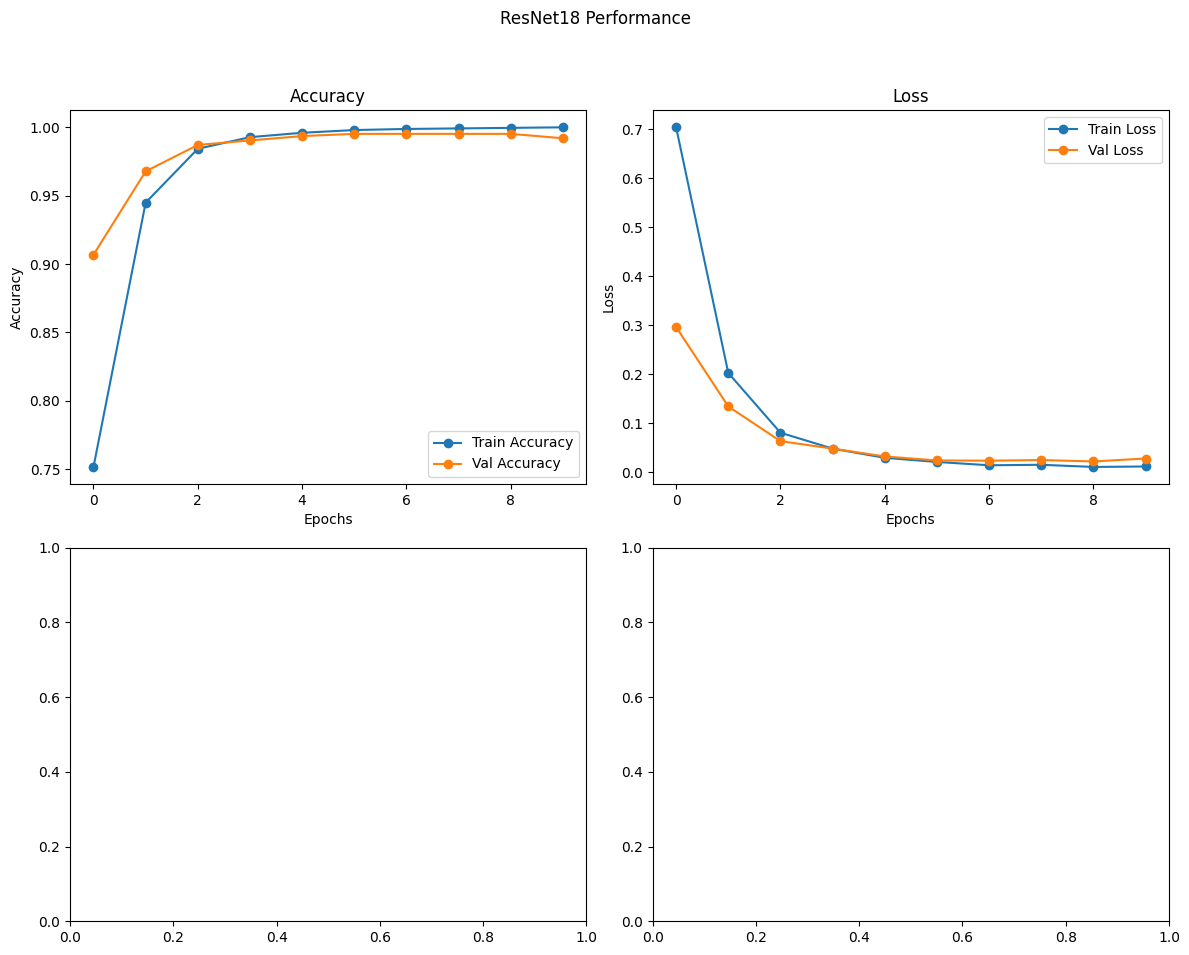

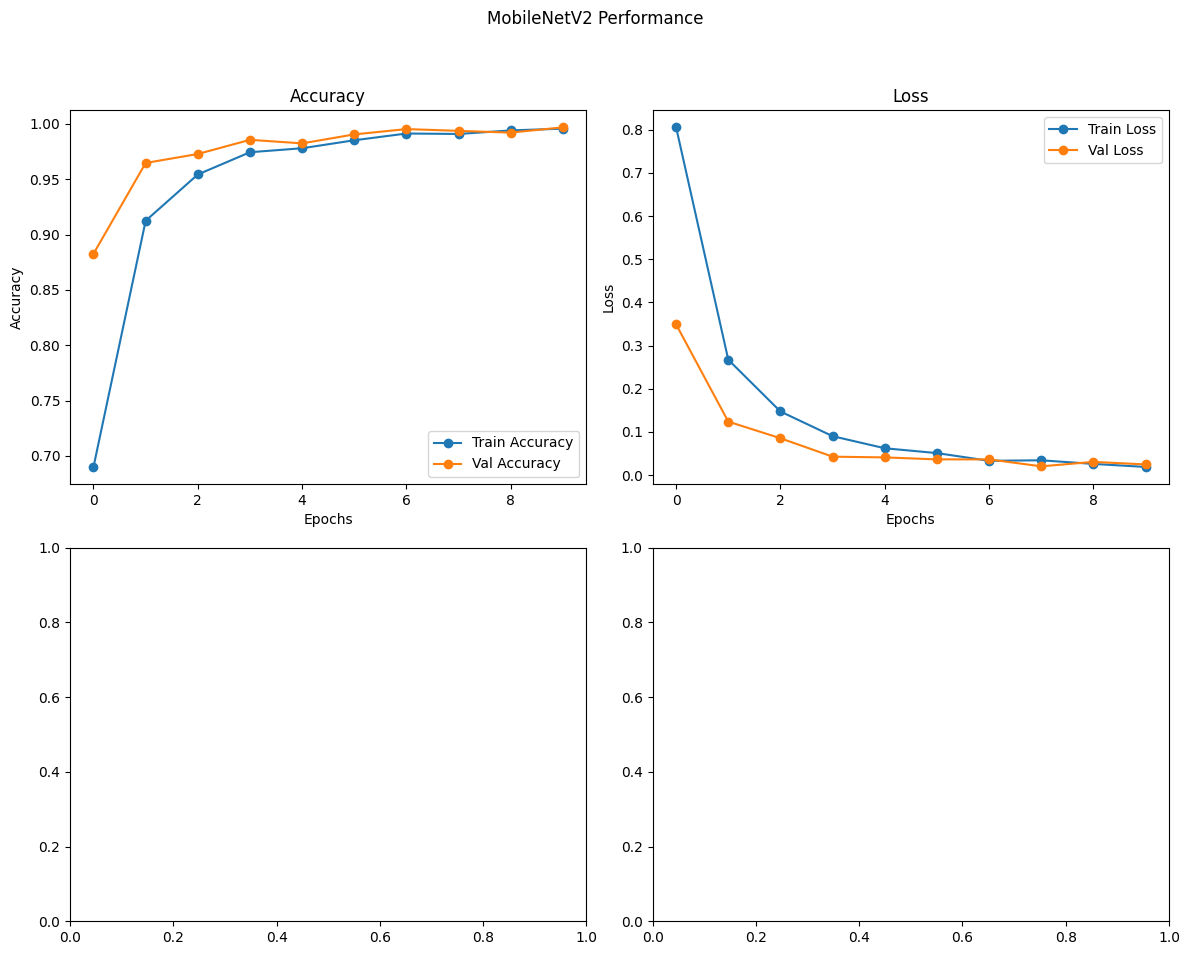

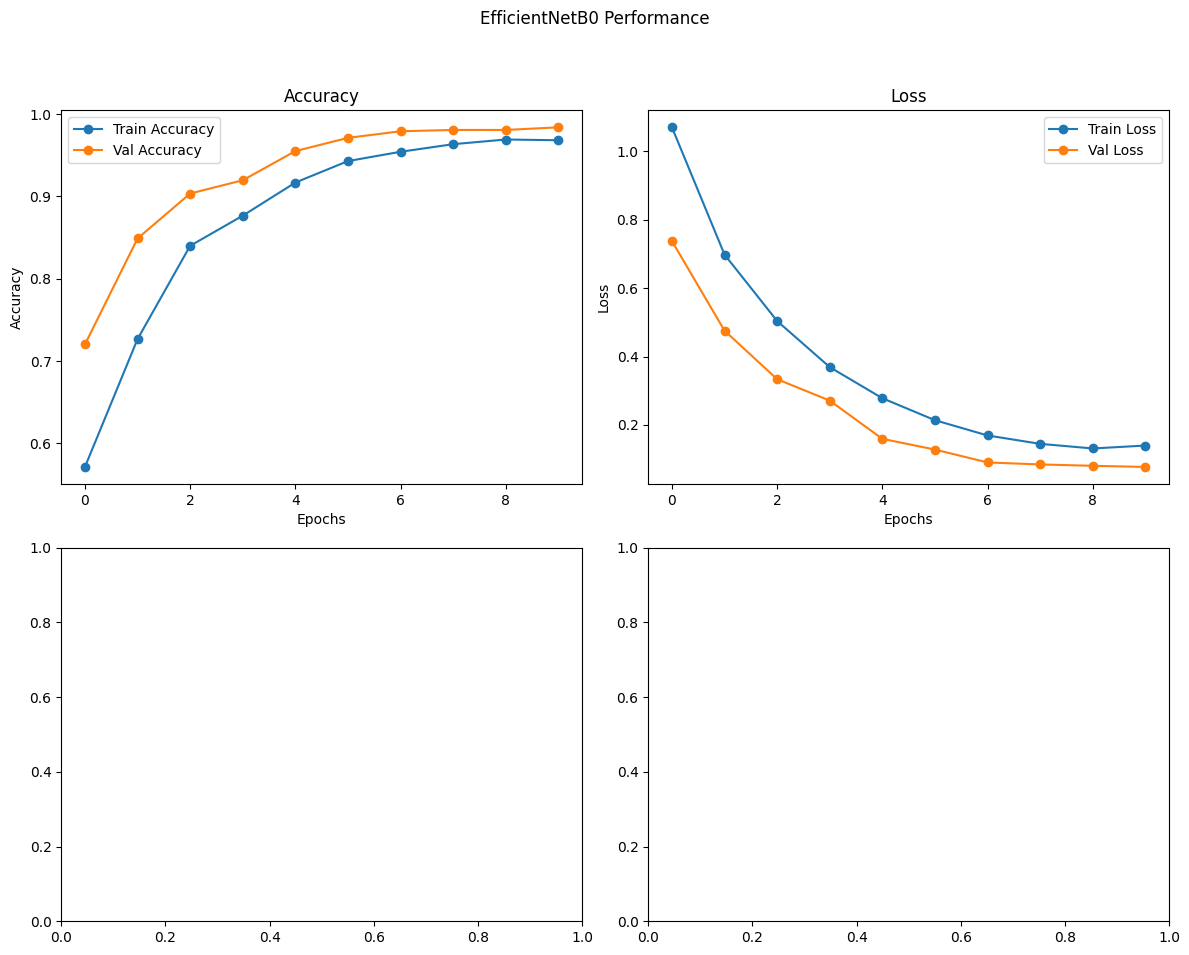

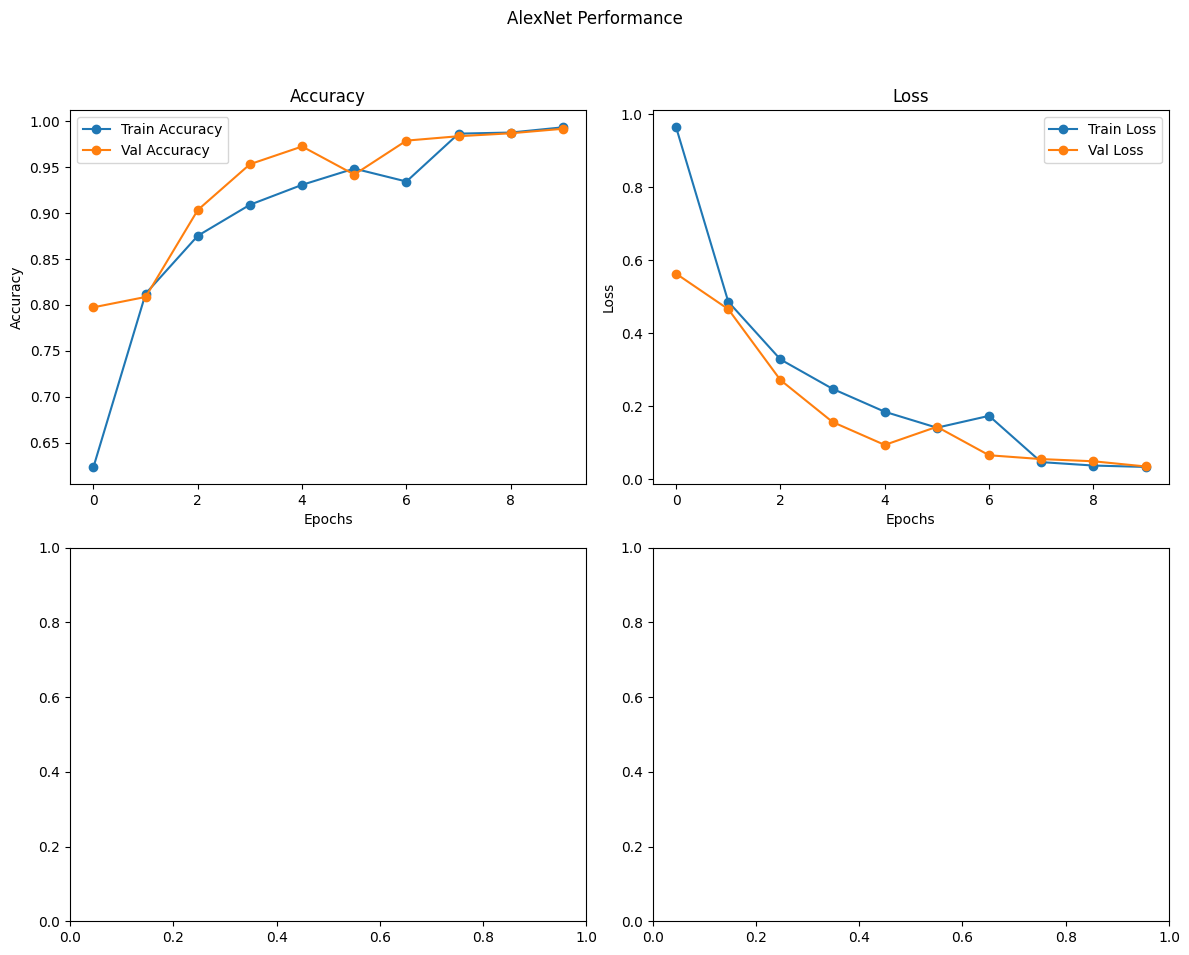

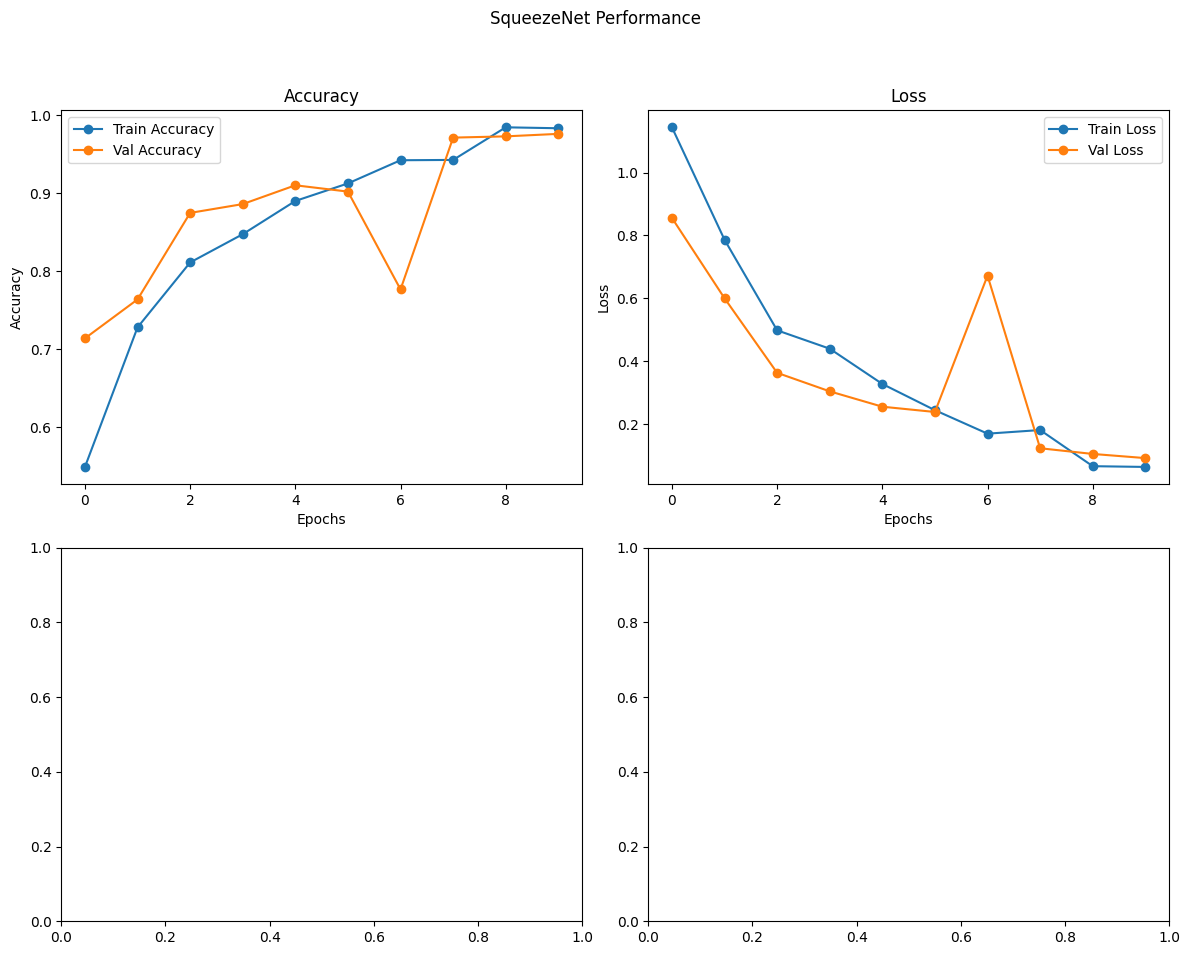

In [14]:
import matplotlib.pyplot as plt

# Sample data
epochs = list(range(10))

# Model Data
model_data = {
    "ResNet18": {
        "train_acc": [0.7516, 0.9449, 0.9843, 0.9928, 0.9960, 0.9980, 0.9988, 0.9992, 0.9996, 1.0000],
        "val_acc": [0.9068, 0.9678, 0.9871, 0.9904, 0.9936, 0.9952, 0.9952, 0.9952, 0.9952, 0.9920],
        "train_loss": [0.7040, 0.2024, 0.0804, 0.0479, 0.0291, 0.0207, 0.0139, 0.0149, 0.0105, 0.0114],
        "val_loss": [0.2962, 0.1340, 0.0632, 0.0479, 0.0319, 0.0237, 0.0233, 0.0246, 0.0217, 0.0277]
    },
    "MobileNetV2": {
        "train_acc": [0.6901, 0.9124, 0.9542, 0.9743, 0.9779, 0.9851, 0.9912, 0.9908, 0.9940, 0.9956],
        "val_acc": [0.8826, 0.9646, 0.9727, 0.9855, 0.9823, 0.9904, 0.9952, 0.9936, 0.9920, 0.9968],
        "train_loss": [0.8058, 0.2672, 0.1472, 0.0900, 0.0620, 0.0508, 0.0329, 0.0341, 0.0257, 0.0187],
        "val_loss": [0.3490, 0.1237, 0.0852, 0.0425, 0.0408, 0.0362, 0.0362, 0.0201, 0.0304, 0.0245]
    },
    "EfficientNetB0": {
        "train_acc": [0.5715, 0.7267, 0.8400, 0.8766, 0.9168, 0.9429, 0.9542, 0.9634, 0.9691, 0.9682],
        "val_acc": [0.7203, 0.8489, 0.9035, 0.9196, 0.9550, 0.9711, 0.9791, 0.9807, 0.9807, 0.9839],
        "train_loss": [1.0700, 0.6978, 0.5038, 0.3690, 0.2781, 0.2138, 0.1692, 0.1447, 0.1312, 0.1397],
        "val_loss": [0.7375, 0.4755, 0.3336, 0.2711, 0.1593, 0.1280, 0.0903, 0.0845, 0.0805, 0.0772]
    },
    "AlexNet": {
        "train_acc": [0.6234, 0.8123, 0.8754, 0.9092, 0.9309, 0.9486, 0.9345, 0.9867, 0.9879, 0.9936],
        "val_acc": [0.7974, 0.8087, 0.9035, 0.9534, 0.9727, 0.9421, 0.9791, 0.9839, 0.9871, 0.9920],
        "train_loss": [0.9648, 0.4868, 0.3288, 0.2482, 0.1854, 0.1417, 0.1742, 0.0474, 0.0380, 0.0342],
        "val_loss": [0.5637, 0.4665, 0.2723, 0.1573, 0.0945, 0.1442, 0.0662, 0.0557, 0.0497, 0.0355]
    },
    "SqueezeNet": {
        "train_acc": [0.5490, 0.7279, 0.8111, 0.8473, 0.8899, 0.9124, 0.9421, 0.9425, 0.9843, 0.9831],
        "val_acc": [0.7138, 0.7637, 0.8746, 0.8859, 0.9100, 0.9019, 0.7765, 0.9711, 0.9727, 0.9759],
        "train_loss": [1.1439, 0.7864, 0.4984, 0.4400, 0.3279, 0.2445, 0.1699, 0.1814, 0.0665, 0.0641],
        "val_loss": [0.8558, 0.6003, 0.3633, 0.3044, 0.2556, 0.2388, 0.6723, 0.1235, 0.1054, 0.0922]
    }
}

# Plotting
for model, data in model_data.items():
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f'{model} Performance')

    # Training and Validation Accuracy
    axs[0, 0].plot(epochs, data["train_acc"], label='Train Accuracy', marker='o')
    axs[0, 0].plot(epochs, data["val_acc"], label='Val Accuracy', marker='o')
    axs[0, 0].set_title('Accuracy')
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].legend()

    # Training and Validation Loss
    axs[0, 1].plot(epochs, data["train_loss"], label='Train Loss', marker='o')
    axs[0, 1].plot(epochs, data["val_loss"], label='Val Loss', marker='o')
    axs[0, 1].set_title('Loss')
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


C:\Users\venug\AppData\Local\Temp\ipykernel_9276\2743309888.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_paths[model_name], ma

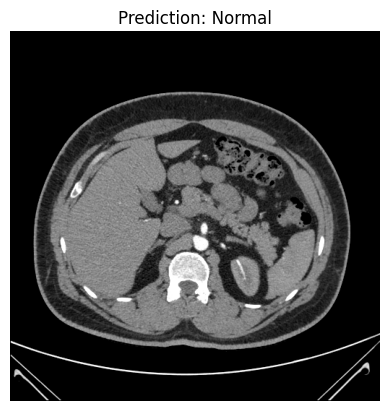

In [3]:
# Import necessary libraries
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import os

# Define the classes
classes = ['Cyst', 'Normal', 'Stone', 'Tumor']

# Define model paths (adjust these paths accordingly)
model_paths = {
    'AlexNet': 'alexnet_fine_tuned.pth',
    'ResNet18': 'resnet18_fine_tuned.pth',
    'MobileNet': 'mobilenet_v2_fine_tuned.pth',
    'SqueezeNet': 'squeezenet_fine_tuned.pth',
    'EfficientNet': 'efficientnet_b0_fine_tuned.pth',
}

# Load model function
def load_model(model_name):
    if model_name == 'AlexNet':
        model = models.alexnet(pretrained=False)
        model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, len(classes))
    elif model_name == 'ResNet18':
        model = models.resnet18(pretrained=False)
        model.fc = torch.nn.Linear(model.fc.in_features, len(classes))
    elif model_name == 'MobileNet':
        model = models.mobilenet_v2(pretrained=False)
        model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, len(classes))
    elif model_name == 'SqueezeNet':
        model = models.squeezenet1_0(pretrained=False)
        model.classifier[1] = torch.nn.Conv2d(512, len(classes), kernel_size=(1, 1))
    elif model_name == 'EfficientNet':
        model = models.efficientnet_b0(pretrained=False)
        model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, len(classes))

    # Load the saved model weights
    model.load_state_dict(torch.load(model_paths[model_name], map_location=torch.device('cpu')))
    model.eval()
    return model

# Define image preprocessing
def preprocess_image(image):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
    return preprocess(image).unsqueeze(0)

# Function to predict the class of an image
def predict_image(model_name, image_path):
    # Load the model
    model = load_model(model_name)

    # Load and preprocess the image
    image = Image.open(image_path)
    input_tensor = preprocess_image(image)

    # Make predictions
    with torch.no_grad():
        outputs = model(input_tensor)
        _, preds = torch.max(outputs, 1)
        predicted_class = classes[preds.item()]

    # Display the image and prediction
    plt.imshow(image)
    plt.title(f'Prediction: {predicted_class}')
    plt.axis('off')
    plt.show()

# Example usage
# Replace 'path_to_your_image.jpg' with the path to the image you want to predict
image_path = r'C:\Users\venug\Downloads\archive\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone\Normal\Normal- (2).jpg'
model_name = 'ResNet18'  # Choose the model you want to use
predict_image(model_name, image_path)


C:\Users\venug\AppData\Local\Temp\ipykernel_9276\2743309888.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_paths[model_name], ma

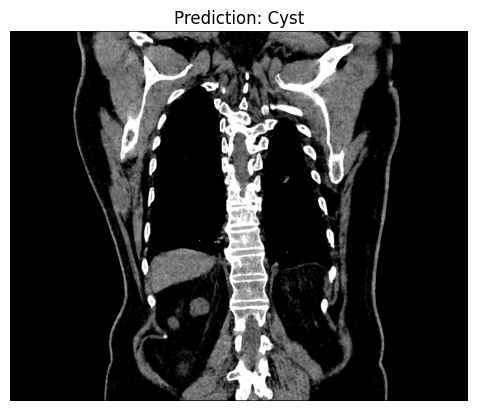

In [5]:
image_path = r'C:\Users\venug\Downloads\archive\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone\Cyst\Cyst- (1).jpg'
model_name = 'ResNet18'  # Choose the model you want to use
predict_image(model_name, image_path)